In [2]:

!pip install librosa soundfile scikit-learn pandas matplotlib

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

os.makedirs('/content/drive/MyDrive/Emotion_Classifier', exist_ok=True)


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving Audio_Speech_Actors_01-24.zip to Audio_Speech_Actors_01-24.zip
Saving Audio_Song_Actors_01-24.zip to Audio_Song_Actors_01-24.zip


In [ ]:
import zipfile
import os

os.makedirs("/content/drive/MyDrive/Emotion_Classifier/Audio_Speech_Actors_01-24", exist_ok=True)
os.makedirs("/content/drive/MyDrive/Emotion_Classifier/Audio_Song_Actors_01-24", exist_ok=True)

with zipfile.ZipFile("Audio_Speech_Actors_01-24.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Emotion_Classifier/Audio_Speech_Actors_01-24")

with zipfile.ZipFile("Audio_Song_Actors_01-24.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Emotion_Classifier/Audio_Song_Actors_01-24")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 26.1 MB/s eta 0:00:00


In [ ]:
import resampy
import os
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from tqdm import tqdm

emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
def extract_features(file_path):
    try:
        X, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        features = []

        # MFCC
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        features.extend(mfccs)

        # Chroma
        stft = np.abs(librosa.stft(X))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        features.extend(chroma)

        # Mel Spectrogram
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        features.extend(mel)

        return np.array(features)
    except Exception as e:
        print(f"❌ Error: {file_path} – {e}")
        return None

def get_emotion_from_filename(filename):
    try:
        parts = filename.split("-")
        emotion_code = parts[2]
        return emotion_dict.get(emotion_code)
    except:
        return None

base_dir = '/content/drive/MyDrive/Emotion_Classifier'
folders = ['Audio_Speech_Actors_01-24', 'Audio_Song_Actors_01-24']
all_data = []

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for root, _, files in os.walk(folder_path):
        for file in tqdm(files):
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                label = get_emotion_from_filename(file)
                if label:
                    features = extract_features(file_path)
                    if features is not None:
                        all_data.append(np.append(features, label))

feature_len = len(all_data[0]) - 1
columns = [f'feature_{i}' for i in range(feature_len)] + ['label']
df = pd.DataFrame(all_data, columns=columns)

csv_path = os.path.join(base_dir, 'features.csv')
df.to_csv(csv_path, index=False)
print(f"✅ Feature dataset saved to: {csv_path}")


0it [00:00, ?it/s]
100%|██████████| 60/60 [00:19<00:00,  3.06it/s]
0it [00:00, ?it/s]
100%|██████████| 44/44 [00:16<00:00,  2.64it/s]
0it [00:00, ?it/s]
100%|██████████| 44/44 [00:17<00:00,  2.52it/s]


✅ Feature dataset saved to: /content/drive/MyDrive/Emotion_Classifier/features.csv


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


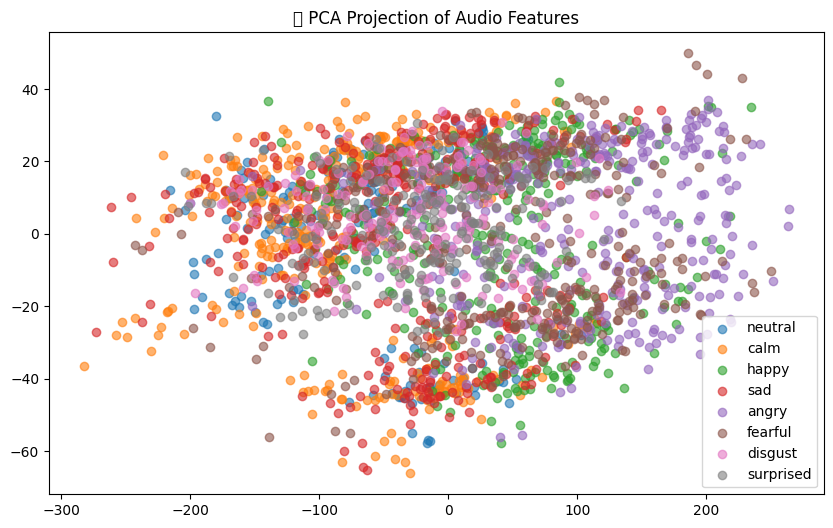

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Emotion_Classifier/features.csv')
X = df.drop('label', axis=1)
y = df['label']

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10,6))
for emotion in y.unique():
    idx = y == emotion
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=emotion, alpha=0.6)
plt.legend()
plt.title("📊 PCA Projection of Audio Features")
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('/content/drive/MyDrive/Emotion_Classifier/features.csv')

X = df.drop('label', axis=1)
y = df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"✅ Train size: {X_train.shape}, Validation size: {X_val.shape}")


✅ Train size: (1961, 180), Validation size: (491, 180)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, max_depth=30, class_weight='balanced', random_state=42)

model.fit(X_train, y_train)

print("✅ Model trained successfully")


✅ Model trained successfully


🎯 Accuracy: 0.6822810590631364
🎯 F1 Score: 0.6812262991018585

📋 Classification Report:
               precision    recall  f1-score   support

       angry       0.78      0.76      0.77        75
        calm       0.72      0.91      0.80        75
     disgust       0.48      0.56      0.52        39
     fearful       0.70      0.56      0.62        75
       happy       0.66      0.65      0.66        75
     neutral       0.93      0.68      0.79        38
         sad       0.66      0.68      0.67        75
   surprised       0.53      0.51      0.52        39

    accuracy                           0.68       491
   macro avg       0.68      0.67      0.67       491
weighted avg       0.69      0.68      0.68       491



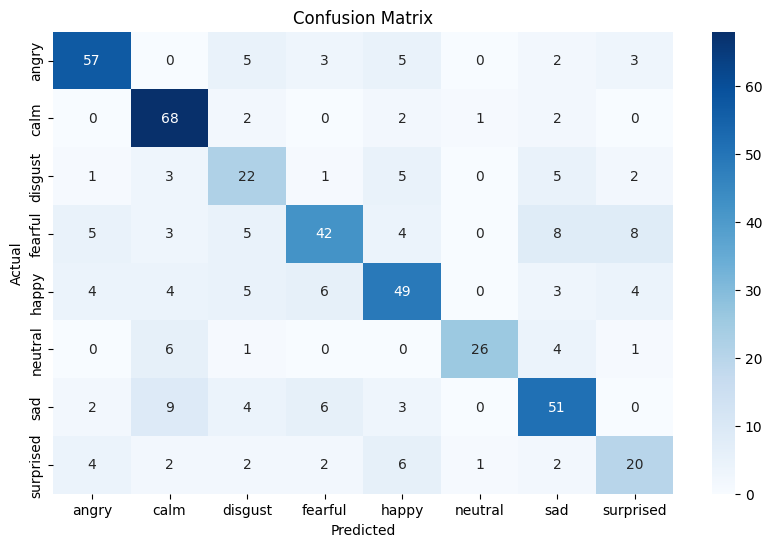

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_val)

print("🎯 Accuracy:", accuracy_score(y_val, y_pred))
print("🎯 F1 Score:", f1_score(y_val, y_pred, average='weighted'))
print("\n📋 Classification Report:\n", classification_report(y_val, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import joblib

model_path = '/content/drive/MyDrive/Emotion_Classifier/random_forest_model.pkl'
joblib.dump(model, model_path)

print(f"✅ Random Forest model saved at: {model_path}")


✅ Random Forest model saved at: /content/drive/MyDrive/Emotion_Classifier/random_forest_model.pkl


In [ ]:
le_path = '/content/drive/MyDrive/Emotion_Classifier/label_encoder.pkl'
joblib.dump(le, le_path)

print(f"✅ Label encoder saved at: {le_path}")


✅ Label encoder saved at: /content/drive/MyDrive/Emotion_Classifier/label_encoder.pkl


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_val, y_pred, target_names=le.classes_)
with open('/content/drive/MyDrive/Emotion_Classifier/rf_classification_report.txt', 'w') as f:
    f.write(report)

print("✅ Classification report saved as .txt")


✅ Classification report saved as .txt


✅ Confusion matrix saved as PNG


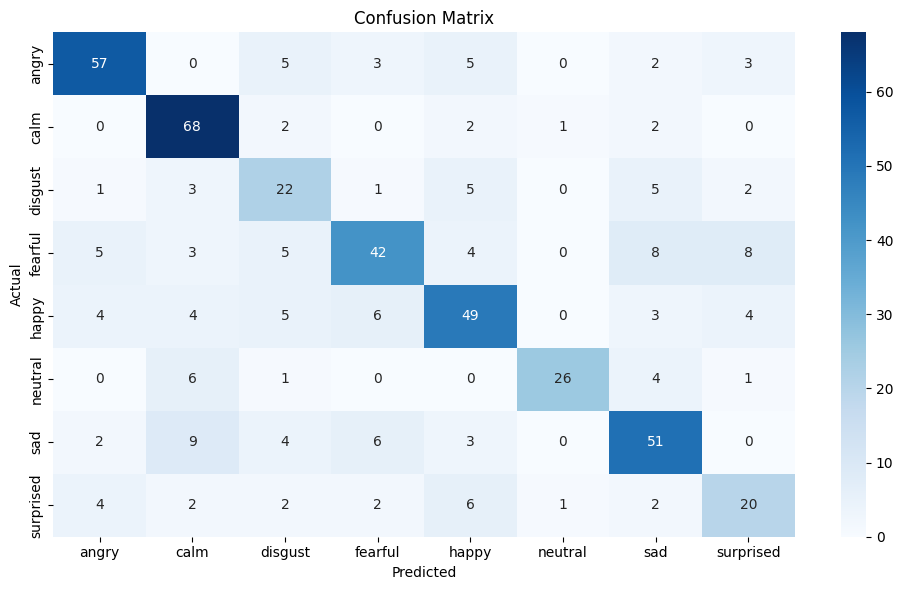

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Emotion_Classifier/rf_confusion_matrix.png')
print("✅ Confusion matrix saved as PNG")


In [ ]:
import librosa
import numpy as np
def add_noise(data, noise_level=0.005):
    noise = np.random.randn(len(data))
    return (data + noise_level * noise).astype(np.float32)

def pitch_shift(y, sampling_rate, steps=2):
    return librosa.effects.pitch_shift(y=y, sr=sampling_rate, n_steps=steps)


def time_stretch(data, rate=0.9):
    return librosa.effects.time_stretch(data, rate)

def extract_mfcc_from_raw(y, sr=22050, max_len=130):
    try:
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_mel = librosa.power_to_db(mel)
        if log_mel.shape[1] < max_len:
            pad_width = max_len - log_mel.shape[1]
            log_mel = np.pad(log_mel, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            log_mel = log_mel[:, :max_len]
        return log_mel
    except Exception as e:
        print(f"❌ Failed to extract MFCC from raw: {e}")
        return None

def extract_mel_spectrogram(file_path, max_len=130):
    try:
        y, sr = librosa.load(file_path, sr=22050)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_mel = librosa.power_to_db(mel)

        if log_mel.shape[1] < max_len:
            pad_width = max_len - log_mel.shape[1]
            log_mel = np.pad(log_mel, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            log_mel = log_mel[:, :max_len]

        return log_mel
    except Exception as e:
        print(f"❌ Failed to process {file_path} – {e}")
        return None


In [ ]:
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import numpy as np

base_dir = '/content/drive/MyDrive/Emotion_Classifier'
folders = ['Audio_Speech_Actors_01-24', 'Audio_Song_Actors_01-24']

emotion_dict = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

X = []
y = []

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for root, _, files in os.walk(folder_path):
        for file in tqdm(files):
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                label_code = file.split("-")[2]
                label = emotion_dict.get(label_code)
                if label:
                    try:
                        y_raw, sr = librosa.load(file_path, sr=22050)

                        # 1. Original
                        mel_spec = extract_mfcc_from_raw(y_raw, sr)
                        if mel_spec is not None:
                            X.append(mel_spec)
                            y.append(label)

                        # 2. Add Noise
                        try:
                            aug1 = extract_mfcc_from_raw(add_noise(y_raw), sr)
                            if aug1 is not None:
                                X.append(aug1)
                                y.append(label)
                        except:
                            pass

                        # 3. Pitch Shift
                        try:
                            aug2 = extract_mfcc_from_raw(librosa.effects.pitch_shift(y_raw, sr=sr, n_steps=2), sr)
                            if aug2 is not None:
                                X.append(aug2)
                                y.append(label)
                        except:
                            pass

                        # 4. Time Stretch
                        try:
                            aug3_raw = librosa.effects.time_stretch(y_raw, rate=0.9)
                            aug3 = extract_mfcc_from_raw(aug3_raw, sr)
                            if aug3 is not None:
                                X.append(aug3)
                                y.append(label)
                        except:
                            pass

                    except Exception as e:
                        print(f"❌ Could not process {file_path}: {e}")

X = np.array(X)
y = np.array(y)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

np.save(os.path.join(base_dir, 'X.npy'), X)
np.save(os.path.join(base_dir, 'y.npy'), y_encoded)





0it [00:00, ?it/s]
100%|██████████| 60/60 [00:32<00:00,  1.83it/s]
0it [00:00, ?it/s]
100%|██████████| 44/44 [00:42<00:00,  1.02it/s]
0it [00:00, ?it/s]
100%|██████████| 44/44 [00:24<00:00,  1.80it/s]


NameError: name 'joblib' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


ValueError: mount failed

In [ ]:
import joblib
joblib.dump(le, os.path.join(base_dir, 'cnn_label_encoder.pkl'))
print(f"✅ Saved X: {X.shape}, y: {y_encoded.shape}")


✅ Saved X: (9808, 128, 130), y: (9808,)


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

base_dir = '/content/drive/MyDrive/Emotion_Classifier'

X = np.load(os.path.join(base_dir, 'X.npy'))
y = np.load(os.path.join(base_dir, 'y.npy'))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")



Train: (7846, 128, 130), Val: (1962, 128, 130)


In [ ]:
from sklearn.utils import resample
import numpy as np

def oversample_class(X, y, target_class, factor=1):
    mask = y == target_class
    X_dup = X[mask]
    y_dup = y[mask]
    X_new = np.concatenate([X, np.tile(X_dup, (factor, 1, 1))])
    y_new = np.concatenate([y, np.tile(y_dup, factor)])
    return X_new, y_new

X_train_os, y_train_os = X_train.copy(), y_train.copy()
for cls in [3, 4, 6]:
    X_train_os, y_train_os = oversample_class(X_train_os, y_train_os, cls, factor=1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class SpecAugment(Layer):
    def __init__(self, freq_mask_param=8, time_mask_param=8, **kwargs):
        super(SpecAugment, self).__init__(**kwargs)
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param

    def call(self, inputs, training=True):
        if training:

            f = tf.random.uniform([], 0, self.freq_mask_param, dtype=tf.int32)
            f0 = tf.random.uniform([], 0, tf.shape(inputs)[2] - f, dtype=tf.int32)
            freq_mask = tf.concat([
                tf.ones((tf.shape(inputs)[0], tf.shape(inputs)[1], f0)),
                tf.zeros((tf.shape(inputs)[0], tf.shape(inputs)[1], f)),
                tf.ones((tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2] - f0 - f)),
            ], axis=2)
            inputs = inputs * freq_mask

            t = tf.random.uniform([], 0, self.time_mask_param, dtype=tf.int32)
            t0 = tf.random.uniform([], 0, tf.shape(inputs)[1] - t, dtype=tf.int32)
            time_mask = tf.concat([
                tf.ones((tf.shape(inputs)[0], t0, tf.shape(inputs)[2])),
                tf.zeros((tf.shape(inputs)[0], t, tf.shape(inputs)[2])),
                tf.ones((tf.shape(inputs)[0], tf.shape(inputs)[1] - t0 - t, tf.shape(inputs)[2])),
            ], axis=1)
            inputs = inputs * time_mask

        return inputs


In [4]:
!pip install keras-self-attention


  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=bee0246a3003eef4e9977d1af70ffdf823632d2244e61f50043f65a20ad07c1d
  Stored in directory: /root/.cache/pip/wheels/46/f9/96/709295c836133071c12a300729fed4027757f889c01695feea
Successfully built keras-self-attention


In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, LayerNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, GlobalAveragePooling1D, LeakyReLU
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.models import Model
import numpy as np

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = Conv1D(128, kernel_size=5, padding='same')(input_layer)
x = LayerNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(256, kernel_size=3, padding='same')(x)
x = LayerNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Conv1D(512, kernel_size=3, padding='same')(x)
x = LayerNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = SeqSelfAttention(attention_activation='sigmoid')(x)
x = GlobalAveragePooling1D()(x)

x = Dense(256)(x)
x = LeakyReLU()(x)
x = Dropout(0.4)(x)

x = Dense(128)(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)

output = Dense(len(np.unique(y_train)), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)


In [ ]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.losses import CategoricalFocalCrossentropy
import numpy as np

num_classes = len(np.unique(y_train))

y_train_cat = to_categorical(y_train_os, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

model.compile(
    loss=CategoricalFocalCrossentropy(gamma=2.0),
    optimizer=Adam(learning_rate=3e-4),
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    X_train_os, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=65,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/65
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2233 - loss: 0.3642
Epoch 1: val_loss improved from inf to 0.34740, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.2234 - loss: 0.3642 - val_accuracy: 0.2355 - val_loss: 0.3474 - learning_rate: 3.0000e-04
Epoch 2/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2960 - loss: 0.3206
Epoch 2: val_loss improved from 0.34740 to 0.32294, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.2960 - loss: 0.3205 - val_accuracy: 0.2574 - val_loss: 0.3229 - learning_rate: 3.0000e-04
Epoch 3/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3007 - loss: 0.3063
Epoch 3: val_loss did not improve from 0.32294
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.3008 - loss: 0.3063 - val_accuracy: 0.2329 - val_loss: 0.3371 - learning_rate: 3.0000e-04
Epoch 4/65
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3319 - loss: 0.2920
Epoch 4: val_loss improved from 0.32294 to 0.30301, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.3319 - loss: 0.2920 - val_accuracy: 0.2956 - val_loss: 0.3030 - learning_rate: 3.0000e-04
Epoch 5/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3495 - loss: 0.2747
Epoch 5: val_loss improved from 0.30301 to 0.29872, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.3495 - loss: 0.2747 - val_accuracy: 0.2854 - val_loss: 0.2987 - learning_rate: 3.0000e-04
Epoch 6/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3689 - loss: 0.2667
Epoch 6: val_loss improved from 0.29872 to 0.26523, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.3689 - loss: 0.2666 - val_accuracy: 0.3614 - val_loss: 0.2652 - learning_rate: 3.0000e-04
Epoch 7/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3826 - loss: 0.2552
Epoch 7: val_loss improved from 0.26523 to 0.25561, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.3826 - loss: 0.2551 - val_accuracy: 0.3639 - val_loss: 0.2556 - learning_rate: 3.0000e-04
Epoch 8/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4008 - loss: 0.2389
Epoch 8: val_loss improved from 0.25561 to 0.24637, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.4008 - loss: 0.2389 - val_accuracy: 0.3812 - val_loss: 0.2464 - learning_rate: 3.0000e-04
Epoch 9/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4413 - loss: 0.2227
Epoch 9: val_loss improved from 0.24637 to 0.23345, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.4412 - loss: 0.2228 - val_accuracy: 0.4123 - val_loss: 0.2334 - learning_rate: 3.0000e-04
Epoch 10/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4372 - loss: 0.2217
Epoch 10: val_loss improved from 0.23345 to 0.21746, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4372 - loss: 0.2217 - val_accuracy: 0.4358 - val_loss: 0.2175 - learning_rate: 3.0000e-04
Epoch 11/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4725 - loss: 0.2068
Epoch 11: val_loss improved from 0.21746 to 0.20847, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.4725 - loss: 0.2068 - val_accuracy: 0.4623 - val_loss: 0.2085 - learning_rate: 3.0000e-04
Epoch 12/65
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5132 - loss: 0.1912
Epoch 12: val_loss improved from 0.20847 to 0.20770, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5132 - loss: 0.1912 - val_accuracy: 0.4475 - val_loss: 0.2077 - learning_rate: 3.0000e-04
Epoch 13/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5203 - loss: 0.1830
Epoch 13: val_loss improved from 0.20770 to 0.17639, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5204 - loss: 0.1830 - val_accuracy: 0.5357 - val_loss: 0.1764 - learning_rate: 3.0000e-04
Epoch 14/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5527 - loss: 0.1700
Epoch 14: val_loss improved from 0.17639 to 0.17188, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5528 - loss: 0.1700 - val_accuracy: 0.5387 - val_loss: 0.1719 - learning_rate: 3.0000e-04
Epoch 15/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5741 - loss: 0.1570
Epoch 15: val_loss improved from 0.17188 to 0.16703, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5741 - loss: 0.1570 - val_accuracy: 0.5637 - val_loss: 0.1670 - learning_rate: 3.0000e-04
Epoch 16/65
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5959 - loss: 0.1475
Epoch 16: val_loss did not improve from 0.16703
358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5959 - loss: 0.1475 - val_accuracy: 0.5683 - val_loss: 0.1726 - learning_rate: 3.0000e-04
Epoch 17/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6180 - loss: 0.1389
Epoch 17: val_loss improved from 0.16703 to 0.13391, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.6180 - loss: 0.1389 - val_accuracy: 0.6213 - val_loss: 0.1339 - learning_rate: 3.0000e-04
Epoch 18/65
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6337 - loss: 0.1295
Epoch 18: val_loss did not improve from 0.13391
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6337 - loss: 0.1295 - val_accuracy: 0.6198 - val_loss: 0.1482 - learning_rate: 3.0000e-04
Epoch 19/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6489 - loss: 0.1230
Epoch 19: val_loss improved from 0.13391 to 0.12774, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6489 - loss: 0.1230 - val_accuracy: 0.6437 - val_loss: 0.1277 - learning_rate: 3.0000e-04
Epoch 20/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6583 - loss: 0.1178
Epoch 20: val_loss did not improve from 0.12774
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6584 - loss: 0.1178 - val_accuracy: 0.6295 - val_loss: 0.1359 - learning_rate: 3.0000e-04
Epoch 21/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6726 - loss: 0.1122
Epoch 21: val_loss improved from 0.12774 to 0.12657, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6726 - loss: 0.1122 - val_accuracy: 0.6458 - val_loss: 0.1266 - learning_rate: 3.0000e-04
Epoch 22/65
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6873 - loss: 0.1086
Epoch 22: val_loss did not improve from 0.12657
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6872 - loss: 0.1086 - val_accuracy: 0.6560 - val_loss: 0.1295 - learning_rate: 3.0000e-04
Epoch 23/65
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6987 - loss: 0.0996
Epoch 23: val_loss did not improve from 0.12657
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.6987 - loss: 0.0996 - val_accuracy: 0.6458 - val_loss: 0.1303 - learning_rate: 3.0000e-04
Epoch 24/65
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7087 - loss: 0.0965
Epoch 24: val_loss improved from 0.12657 to 0.10689, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7087 - loss: 0.0965 - val_accuracy: 0.7049 - val_loss: 0.1069 - learning_rate: 3.0000e-04
Epoch 25/65
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7210 - loss: 0.0933
Epoch 25: val_loss improved from 0.10689 to 0.10321, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7209 - loss: 0.0933 - val_accuracy: 0.7064 - val_loss: 0.1032 - learning_rate: 3.0000e-04
Epoch 26/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7406 - loss: 0.0847
Epoch 26: val_loss did not improve from 0.10321
358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7406 - loss: 0.0847 - val_accuracy: 0.6988 - val_loss: 0.1066 - learning_rate: 3.0000e-04
Epoch 27/65
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7326 - loss: 0.0877
Epoch 27: val_loss did not improve from 0.10321
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7326 - loss: 0.0877 - val_accuracy: 0.7013 - val_loss: 0.1037 - learning_rate: 3.0000e-04
Epoch 28/65
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7427 - loss: 0.0817
Epoch 28: val_loss improved from 0.10321 to 0.10047, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.7427 - loss: 0.0817 - val_accuracy: 0.7222 - val_loss: 0.1005 - learning_rate: 3.0000e-04
Epoch 29/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7596 - loss: 0.0731
Epoch 29: val_loss improved from 0.10047 to 0.09728, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7596 - loss: 0.0732 - val_accuracy: 0.7197 - val_loss: 0.0973 - learning_rate: 3.0000e-04
Epoch 30/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7742 - loss: 0.0708
Epoch 30: val_loss improved from 0.09728 to 0.09339, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7742 - loss: 0.0708 - val_accuracy: 0.7329 - val_loss: 0.0934 - learning_rate: 3.0000e-04
Epoch 31/65
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7718 - loss: 0.0708
Epoch 31: val_loss did not improve from 0.09339
358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7718 - loss: 0.0708 - val_accuracy: 0.7380 - val_loss: 0.0941 - learning_rate: 3.0000e-04
Epoch 32/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7803 - loss: 0.0681
Epoch 32: val_loss improved from 0.09339 to 0.09144, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7803 - loss: 0.0681 - val_accuracy: 0.7385 - val_loss: 0.0914 - learning_rate: 3.0000e-04
Epoch 33/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7792 - loss: 0.0674
Epoch 33: val_loss improved from 0.09144 to 0.08123, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7792 - loss: 0.0674 - val_accuracy: 0.7655 - val_loss: 0.0812 - learning_rate: 3.0000e-04
Epoch 34/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7990 - loss: 0.0609
Epoch 34: val_loss did not improve from 0.08123
358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7989 - loss: 0.0610 - val_accuracy: 0.7360 - val_loss: 0.0922 - learning_rate: 3.0000e-04
Epoch 35/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8040 - loss: 0.0590
Epoch 35: val_loss did not improve from 0.08123
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8039 - loss: 0.0590 - val_accuracy: 0.7650 - val_loss: 0.0850 - learning_rate: 3.0000e-04
Epoch 36/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8096 - loss: 0.0599
Epoch 36: val_loss improved from 0.08123 to 0.08065, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8096 - loss: 0.0599 - val_accuracy: 0.7706 - val_loss: 0.0807 - learning_rate: 3.0000e-04
Epoch 37/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8222 - loss: 0.0524
Epoch 37: val_loss did not improve from 0.08065
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8222 - loss: 0.0524 - val_accuracy: 0.7508 - val_loss: 0.0894 - learning_rate: 3.0000e-04
Epoch 38/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8186 - loss: 0.0567
Epoch 38: val_loss did not improve from 0.08065
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8186 - loss: 0.0567 - val_accuracy: 0.7625 - val_loss: 0.0845 - learning_rate: 3.0000e-04
Epoch 39/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8259 - loss: 0.0524
Epoch 39: val_loss did not improve from 0.08065
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8259 - loss: 0.0524 - val_accuracy: 0.7844 - val_loss: 0.0838 - learning_rate: 3.0000e-04
Epoch 

358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8564 - loss: 0.0416 - val_accuracy: 0.7829 - val_loss: 0.0787 - learning_rate: 1.5000e-04
Epoch 41/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8726 - loss: 0.0348
Epoch 41: val_loss improved from 0.07874 to 0.07526, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8726 - loss: 0.0348 - val_accuracy: 0.8012 - val_loss: 0.0753 - learning_rate: 1.5000e-04
Epoch 42/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8799 - loss: 0.0332
Epoch 42: val_loss improved from 0.07526 to 0.07159, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8799 - loss: 0.0332 - val_accuracy: 0.8089 - val_loss: 0.0716 - learning_rate: 1.5000e-04
Epoch 43/65
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8728 - loss: 0.0337
Epoch 43: val_loss did not improve from 0.07159
358/358 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8728 - loss: 0.0337 - val_accuracy: 0.7895 - val_loss: 0.0775 - learning_rate: 1.5000e-04
Epoch 44/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8817 - loss: 0.0326
Epoch 44: val_loss did not improve from 0.07159
358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8817 - loss: 0.0326 - val_accuracy: 0.8063 - val_loss: 0.0730 - learning_rate: 1.5000e-04
Epoch 45/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8863 - loss: 0.0301
Epoch 45: val_loss did not improve from 0.07159
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8863 - loss: 0.0301 - val_accuracy: 0.7982 - val_loss: 0.0761 - learning_rate: 1.5000e-04
Epoch 46

358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9045 - loss: 0.0250 - val_accuracy: 0.8165 - val_loss: 0.0706 - learning_rate: 7.5000e-05
Epoch 47/65
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9047 - loss: 0.0255
Epoch 47: val_loss improved from 0.07061 to 0.06825, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9047 - loss: 0.0254 - val_accuracy: 0.8175 - val_loss: 0.0682 - learning_rate: 7.5000e-05
Epoch 48/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9113 - loss: 0.0235
Epoch 48: val_loss did not improve from 0.06825
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9113 - loss: 0.0235 - val_accuracy: 0.8221 - val_loss: 0.0713 - learning_rate: 7.5000e-05
Epoch 49/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9089 - loss: 0.0230
Epoch 49: val_loss did not improve from 0.06825
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9089 - loss: 0.0230 - val_accuracy: 0.8063 - val_loss: 0.0740 - learning_rate: 7.5000e-05
Epoch 50/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9139 - loss: 0.0223
Epoch 50: val_loss did not improve from 0.06825
358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9139 - loss: 0.0223 - val_accuracy: 0.8201 - val_loss: 0.0691 - learning_rate: 7.5000e-05
Epoch 

358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9281 - loss: 0.0188 - val_accuracy: 0.8262 - val_loss: 0.0680 - learning_rate: 1.8750e-05
Epoch 55/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9275 - loss: 0.0183
Epoch 55: val_loss improved from 0.06795 to 0.06772, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9275 - loss: 0.0183 - val_accuracy: 0.8323 - val_loss: 0.0677 - learning_rate: 1.8750e-05
Epoch 56/65
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9282 - loss: 0.0176
Epoch 56: val_loss improved from 0.06772 to 0.06771, saving model to best_model.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9282 - loss: 0.0176 - val_accuracy: 0.8272 - val_loss: 0.0677 - learning_rate: 1.8750e-05
Epoch 57/65
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9304 - loss: 0.0166
Epoch 57: val_loss did not improve from 0.06771
358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9304 - loss: 0.0166 - val_accuracy: 0.8242 - val_loss: 0.0703 - learning_rate: 1.8750e-05
Epoch 58/65
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9227 - loss: 0.0187
Epoch 58: val_loss did not improve from 0.06771
358/358 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9227 - loss: 0.0187 - val_accuracy: 0.8303 - val_loss: 0.0696 - learning_rate: 1.8750e-05
Epoch 59/65
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9315 - loss: 0.0158
Epoch 59: val_loss did not improve from 0.06771
358/358 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9315 - loss: 0.0158 - val_accuracy: 0.8282 - val_loss: 0.0684 - learning_rate: 9.3750e-06
Epoch

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_val, y_pred, digits=4))


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
              precision    recall  f1-score   support

           0     0.8997    0.8638    0.8814       301
           1     0.8431    0.8571    0.8501       301
           2     0.8227    0.7532    0.7864       154
           3     0.8050    0.8505    0.8271       301
           4     0.8690    0.8372    0.8528       301
           5     0.8298    0.7800    0.8041       150
           6     0.7325    0.8007    0.7651       301
           7     0.8311    0.8039    0.8173       153

    accuracy                         0.8272      1962
   macro avg     0.8291    0.8183    0.8230      1962
weighted avg     0.8294    0.8272    0.8277      1962



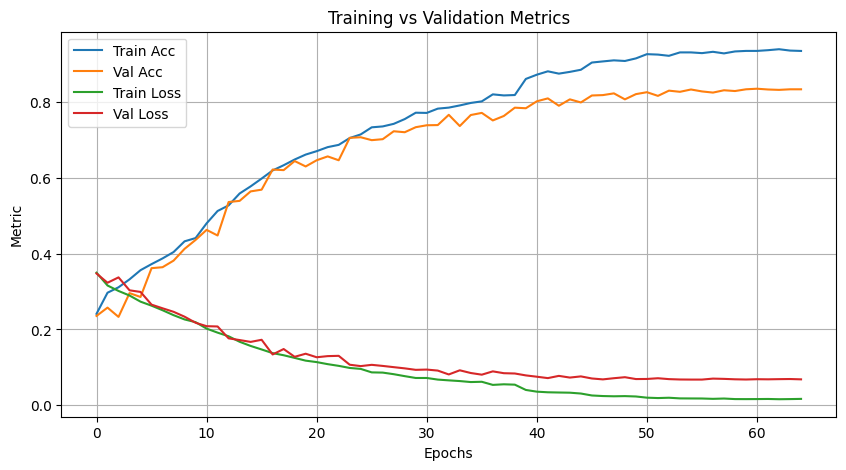

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/Emotion_Classifier/final_emotion_model.h5")
print("✅ Final model saved successfully!")


✅ Final model saved successfully!


In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/Emotion_Classifier/final_emotion_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step


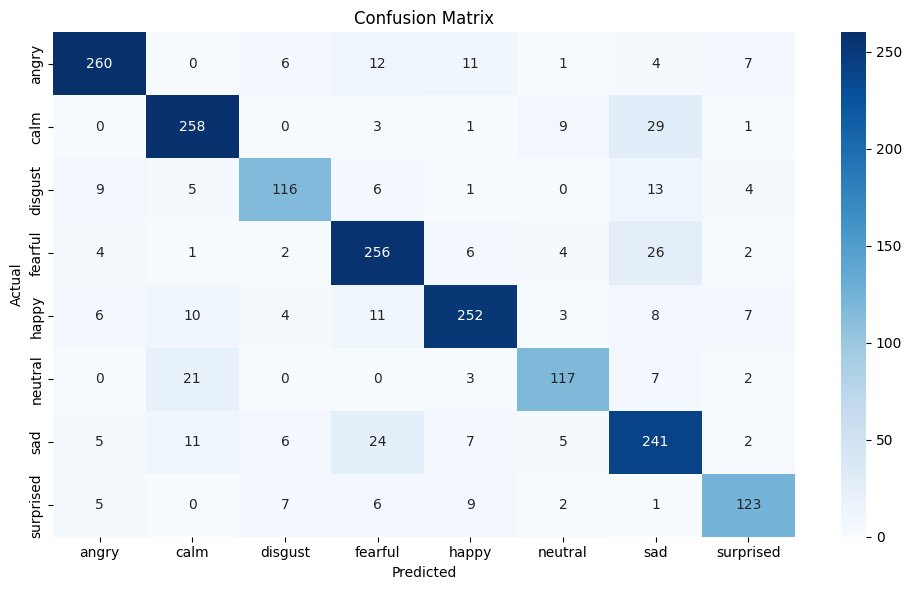

Classification Report:

              precision    recall  f1-score   support

       angry       0.90      0.86      0.88       301
        calm       0.84      0.86      0.85       301
     disgust       0.82      0.75      0.79       154
     fearful       0.81      0.85      0.83       301
       happy       0.87      0.84      0.85       301
     neutral       0.83      0.78      0.80       150
         sad       0.73      0.80      0.77       301
   surprised       0.83      0.80      0.82       153

    accuracy                           0.83      1962
   macro avg       0.83      0.82      0.82      1962
weighted avg       0.83      0.83      0.83      1962



In [6]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model
from keras_self_attention import SeqSelfAttention
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

model_path = "/content/drive/MyDrive/Emotion_Classifier/final_emotion_model.h5"
encoder_path = "/content/drive/MyDrive/Emotion_Classifier/cnn_label_encoder.pkl"

model = load_model(model_path, custom_objects={'SeqSelfAttention': SeqSelfAttention})
le = joblib.load(encoder_path)

X = np.load("/content/drive/MyDrive/Emotion_Classifier/X.npy")
y = np.load("/content/drive/MyDrive/Emotion_Classifier/y.npy")

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

labels = le.classes_
y_true_labels = le.inverse_transform(y_val)
y_pred_labels = le.inverse_transform(y_pred)

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=labels)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=labels))
